# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.676'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(100))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(100, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               66400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 100)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 100)           80800     
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.0433 - val_loss: 0.0255
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0134
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0116
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0103
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 9/1000
585/585 [=========

585/585 [==============================] - 1s 950us/step - loss: 9.9973e-04 - val_loss: 0.0015
Epoch 77/1000
585/585 [==============================] - 1s 953us/step - loss: 9.9489e-04 - val_loss: 0.0019
Epoch 78/1000
585/585 [==============================] - 1s 952us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 79/1000
585/585 [==============================] - 1s 957us/step - loss: 9.8284e-04 - val_loss: 0.0014
Epoch 80/1000
585/585 [==============================] - 1s 950us/step - loss: 9.9505e-04 - val_loss: 0.0012
Epoch 81/1000
585/585 [==============================] - 1s 953us/step - loss: 9.9949e-04 - val_loss: 0.0017
Epoch 82/1000
585/585 [==============================] - 1s 955us/step - loss: 9.9363e-04 - val_loss: 0.0015
Epoch 83/1000
585/585 [==============================] - 1s 950us/step - loss: 9.6665e-04 - val_loss: 0.0015
Epoch 84/1000
585/585 [==============================] - 1s 954us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 85/1000
585/585 [==================

585/585 [==============================] - 1s 950us/step - loss: 7.8269e-04 - val_loss: 7.9652e-04
Epoch 151/1000
585/585 [==============================] - 1s 947us/step - loss: 7.5500e-04 - val_loss: 0.0014
Epoch 152/1000
585/585 [==============================] - 1s 947us/step - loss: 7.0883e-04 - val_loss: 0.0010
Epoch 153/1000
585/585 [==============================] - 1s 938us/step - loss: 6.6387e-04 - val_loss: 0.0013
Epoch 154/1000
585/585 [==============================] - 1s 938us/step - loss: 6.4298e-04 - val_loss: 9.7498e-04
Epoch 155/1000
585/585 [==============================] - 1s 933us/step - loss: 6.5064e-04 - val_loss: 0.0010
Epoch 156/1000
585/585 [==============================] - 1s 934us/step - loss: 6.6910e-04 - val_loss: 0.0011
Epoch 157/1000
585/585 [==============================] - 1s 941us/step - loss: 6.9238e-04 - val_loss: 9.6630e-04
Epoch 158/1000
585/585 [==============================] - 1s 938us/step - loss: 7.4844e-04 - val_loss: 0.0012
Epoch 159/100

585/585 [==============================] - 1s 899us/step - loss: 5.6613e-04 - val_loss: 0.0013
Epoch 224/1000
585/585 [==============================] - 1s 897us/step - loss: 5.2329e-04 - val_loss: 0.0012
Epoch 225/1000
585/585 [==============================] - 1s 902us/step - loss: 6.0256e-04 - val_loss: 7.7509e-04
Epoch 226/1000
585/585 [==============================] - 1s 901us/step - loss: 6.0158e-04 - val_loss: 0.0013
Epoch 227/1000
585/585 [==============================] - 1s 895us/step - loss: 5.9664e-04 - val_loss: 0.0013
Epoch 228/1000
585/585 [==============================] - 1s 895us/step - loss: 5.5633e-04 - val_loss: 6.7122e-04
Epoch 229/1000
585/585 [==============================] - 1s 890us/step - loss: 5.9303e-04 - val_loss: 0.0011
Epoch 230/1000
585/585 [==============================] - 1s 884us/step - loss: 5.4022e-04 - val_loss: 0.0019
Epoch 231/1000
585/585 [==============================] - 1s 883us/step - loss: 8.8355e-04 - val_loss: 8.6832e-04
Epoch 232/100

585/585 [==============================] - 1s 869us/step - loss: 6.6678e-04 - val_loss: 0.0014
Epoch 297/1000
585/585 [==============================] - 1s 865us/step - loss: 5.8998e-04 - val_loss: 0.0015
Epoch 298/1000
585/585 [==============================] - 1s 866us/step - loss: 5.3471e-04 - val_loss: 9.1870e-04
Epoch 299/1000
585/585 [==============================] - 1s 871us/step - loss: 4.6448e-04 - val_loss: 6.3274e-04
Epoch 300/1000
585/585 [==============================] - 1s 865us/step - loss: 5.4557e-04 - val_loss: 9.5220e-04
Epoch 301/1000
585/585 [==============================] - 1s 870us/step - loss: 5.0133e-04 - val_loss: 9.5379e-04
Epoch 302/1000
585/585 [==============================] - 1s 875us/step - loss: 5.1810e-04 - val_loss: 9.2677e-04
Epoch 303/1000
585/585 [==============================] - 1s 872us/step - loss: 5.2538e-04 - val_loss: 0.0013
Epoch 304/1000
585/585 [==============================] - 1s 869us/step - loss: 4.8306e-04 - val_loss: 0.0012
Epoch

585/585 [==============================] - 0s 810us/step - loss: 4.4211e-04 - val_loss: 0.0011
Epoch 370/1000
585/585 [==============================] - 0s 808us/step - loss: 4.8407e-04 - val_loss: 0.0016
Epoch 371/1000
585/585 [==============================] - 0s 807us/step - loss: 4.7414e-04 - val_loss: 0.0011
Epoch 372/1000
585/585 [==============================] - 0s 808us/step - loss: 4.3660e-04 - val_loss: 9.6181e-04
Epoch 373/1000
585/585 [==============================] - 0s 815us/step - loss: 4.0139e-04 - val_loss: 9.3604e-04
Epoch 374/1000
585/585 [==============================] - 0s 813us/step - loss: 4.2912e-04 - val_loss: 7.6321e-04
Epoch 375/1000
585/585 [==============================] - 0s 811us/step - loss: 4.9088e-04 - val_loss: 0.0012
Epoch 376/1000
585/585 [==============================] - 0s 812us/step - loss: 5.1305e-04 - val_loss: 9.6528e-04
Epoch 377/1000
585/585 [==============================] - 0s 822us/step - loss: 4.6845e-04 - val_loss: 6.5906e-04
Epoch

585/585 [==============================] - 0s 797us/step - loss: 3.8265e-04 - val_loss: 0.0011
Epoch 443/1000
585/585 [==============================] - 0s 797us/step - loss: 3.7456e-04 - val_loss: 0.0011
Epoch 444/1000
585/585 [==============================] - 0s 799us/step - loss: 4.0862e-04 - val_loss: 9.5912e-04
Epoch 445/1000
585/585 [==============================] - 0s 800us/step - loss: 4.7677e-04 - val_loss: 0.0013
Epoch 446/1000
585/585 [==============================] - 0s 805us/step - loss: 4.5700e-04 - val_loss: 0.0012
Epoch 447/1000
585/585 [==============================] - 0s 806us/step - loss: 4.7151e-04 - val_loss: 0.0011
Epoch 448/1000
585/585 [==============================] - 0s 800us/step - loss: 4.1028e-04 - val_loss: 0.0013
Epoch 449/1000
585/585 [==============================] - 0s 798us/step - loss: 3.9679e-04 - val_loss: 0.0010
Epoch 450/1000
585/585 [==============================] - 0s 796us/step - loss: 4.2594e-04 - val_loss: 9.5417e-04
Epoch 451/1000
58

Epoch 516/1000
585/585 [==============================] - 0s 797us/step - loss: 4.3466e-04 - val_loss: 8.4992e-04
Epoch 517/1000
585/585 [==============================] - 0s 798us/step - loss: 4.4097e-04 - val_loss: 8.9107e-04
Epoch 518/1000
585/585 [==============================] - 0s 795us/step - loss: 3.8557e-04 - val_loss: 0.0013
Epoch 519/1000
585/585 [==============================] - 0s 820us/step - loss: 3.2660e-04 - val_loss: 0.0011
Epoch 520/1000
585/585 [==============================] - 0s 795us/step - loss: 3.3031e-04 - val_loss: 0.0012
Epoch 521/1000
585/585 [==============================] - 0s 802us/step - loss: 3.4458e-04 - val_loss: 0.0011
Epoch 522/1000
585/585 [==============================] - 0s 799us/step - loss: 3.3821e-04 - val_loss: 0.0013
Epoch 523/1000
585/585 [==============================] - 0s 798us/step - loss: 3.4468e-04 - val_loss: 9.4847e-04
Epoch 524/1000
585/585 [==============================] - 0s 801us/step - loss: 3.4077e-04 - val_loss: 0.001

585/585 [==============================] - 0s 799us/step - loss: 3.4278e-04 - val_loss: 0.0013
Epoch 591/1000
585/585 [==============================] - 0s 799us/step - loss: 3.0022e-04 - val_loss: 0.0010
Epoch 592/1000
585/585 [==============================] - 0s 800us/step - loss: 3.2321e-04 - val_loss: 0.0016
Epoch 593/1000
585/585 [==============================] - 0s 800us/step - loss: 3.0351e-04 - val_loss: 0.0011
Epoch 594/1000
585/585 [==============================] - 0s 794us/step - loss: 3.2358e-04 - val_loss: 0.0012
Epoch 595/1000
585/585 [==============================] - 0s 794us/step - loss: 3.0771e-04 - val_loss: 0.0010
Epoch 596/1000
585/585 [==============================] - 0s 798us/step - loss: 3.1718e-04 - val_loss: 0.0014
Epoch 597/1000
585/585 [==============================] - 0s 802us/step - loss: 2.9165e-04 - val_loss: 0.0014
Epoch 598/1000
585/585 [==============================] - 0s 793us/step - loss: 2.9604e-04 - val_loss: 0.0012
Epoch 599/1000
585/585 [=

585/585 [==============================] - 0s 806us/step - loss: 3.1149e-04 - val_loss: 9.1835e-04
Epoch 665/1000
585/585 [==============================] - 0s 808us/step - loss: 2.9107e-04 - val_loss: 0.0012
Epoch 666/1000
585/585 [==============================] - 0s 805us/step - loss: 3.0366e-04 - val_loss: 0.0016
Epoch 667/1000
585/585 [==============================] - 0s 807us/step - loss: 2.8678e-04 - val_loss: 0.0011
Epoch 668/1000
585/585 [==============================] - 0s 802us/step - loss: 2.9956e-04 - val_loss: 0.0013
Epoch 669/1000
585/585 [==============================] - 0s 807us/step - loss: 2.9504e-04 - val_loss: 8.6818e-04
Epoch 670/1000
585/585 [==============================] - 0s 802us/step - loss: 3.4769e-04 - val_loss: 0.0012
Epoch 671/1000
585/585 [==============================] - 0s 808us/step - loss: 3.0355e-04 - val_loss: 0.0014
Epoch 672/1000
585/585 [==============================] - 0s 804us/step - loss: 2.6807e-04 - val_loss: 0.0016
Epoch 673/1000
58

585/585 [==============================] - 0s 771us/step - loss: 2.8053e-04 - val_loss: 0.0010
Epoch 739/1000
585/585 [==============================] - 0s 772us/step - loss: 2.5863e-04 - val_loss: 0.0014
Epoch 740/1000
585/585 [==============================] - 0s 776us/step - loss: 2.7543e-04 - val_loss: 0.0012
Epoch 741/1000
585/585 [==============================] - 0s 773us/step - loss: 2.8152e-04 - val_loss: 0.0013
Epoch 742/1000
585/585 [==============================] - 0s 775us/step - loss: 2.7983e-04 - val_loss: 0.0012
Epoch 743/1000
585/585 [==============================] - 0s 775us/step - loss: 2.5877e-04 - val_loss: 0.0016
Epoch 744/1000
585/585 [==============================] - 0s 773us/step - loss: 2.8442e-04 - val_loss: 0.0013
Epoch 745/1000
585/585 [==============================] - 0s 773us/step - loss: 2.7114e-04 - val_loss: 0.0014
Epoch 746/1000
585/585 [==============================] - 0s 775us/step - loss: 2.9726e-04 - val_loss: 0.0017
Epoch 747/1000
585/585 [=

585/585 [==============================] - 0s 774us/step - loss: 2.4215e-04 - val_loss: 0.0012
Epoch 813/1000
585/585 [==============================] - 0s 772us/step - loss: 2.6088e-04 - val_loss: 0.0014
Epoch 814/1000
585/585 [==============================] - 0s 776us/step - loss: 2.5385e-04 - val_loss: 0.0015
Epoch 815/1000
585/585 [==============================] - 0s 774us/step - loss: 2.4726e-04 - val_loss: 0.0015
Epoch 816/1000
585/585 [==============================] - 0s 777us/step - loss: 2.4753e-04 - val_loss: 0.0011
Epoch 817/1000
585/585 [==============================] - 0s 774us/step - loss: 2.4954e-04 - val_loss: 0.0015
Epoch 818/1000
585/585 [==============================] - 0s 775us/step - loss: 2.4171e-04 - val_loss: 9.4218e-04
Epoch 819/1000
585/585 [==============================] - 0s 779us/step - loss: 2.5467e-04 - val_loss: 0.0014
Epoch 820/1000
585/585 [==============================] - 0s 776us/step - loss: 2.4281e-04 - val_loss: 9.6315e-04
Epoch 821/1000
58

585/585 [==============================] - 0s 775us/step - loss: 2.3391e-04 - val_loss: 8.9329e-04
Epoch 887/1000
585/585 [==============================] - 0s 774us/step - loss: 2.4332e-04 - val_loss: 0.0011
Epoch 888/1000
585/585 [==============================] - 0s 777us/step - loss: 2.4974e-04 - val_loss: 0.0012
Epoch 889/1000
585/585 [==============================] - 0s 775us/step - loss: 2.7948e-04 - val_loss: 0.0015
Epoch 890/1000
585/585 [==============================] - 0s 773us/step - loss: 2.6573e-04 - val_loss: 0.0016
Epoch 891/1000
585/585 [==============================] - 0s 777us/step - loss: 2.6444e-04 - val_loss: 0.0013
Epoch 892/1000
585/585 [==============================] - 0s 776us/step - loss: 2.3793e-04 - val_loss: 0.0013
Epoch 893/1000
585/585 [==============================] - 0s 776us/step - loss: 2.5481e-04 - val_loss: 0.0014
Epoch 894/1000
585/585 [==============================] - 0s 774us/step - loss: 2.3892e-04 - val_loss: 0.0014
Epoch 895/1000
585/58

585/585 [==============================] - 0s 762us/step - loss: 2.3774e-04 - val_loss: 0.0010
Epoch 961/1000
585/585 [==============================] - 0s 757us/step - loss: 2.4548e-04 - val_loss: 6.8643e-04
Epoch 962/1000
585/585 [==============================] - 0s 760us/step - loss: 2.9544e-04 - val_loss: 9.9492e-04
Epoch 963/1000
585/585 [==============================] - 0s 756us/step - loss: 3.2169e-04 - val_loss: 0.0013
Epoch 964/1000
585/585 [==============================] - 0s 772us/step - loss: 2.7101e-04 - val_loss: 0.0010
Epoch 965/1000
585/585 [==============================] - 0s 761us/step - loss: 2.4758e-04 - val_loss: 0.0015
Epoch 966/1000
585/585 [==============================] - 0s 758us/step - loss: 2.5875e-04 - val_loss: 9.6002e-04
Epoch 967/1000
585/585 [==============================] - 0s 755us/step - loss: 2.5277e-04 - val_loss: 0.0016
Epoch 968/1000
585/585 [==============================] - 0s 759us/step - loss: 2.6886e-04 - val_loss: 0.0011
Epoch 969/100

In [16]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0007547611602481066
MSE Dev: 0.0016754789177474629
MSE Test: 9.52391424670072e-05
MAE Train: 0.013517864486632088
MAE Dev: 0.019576182378203952
MAE Test: 0.008097169460482535


In [15]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

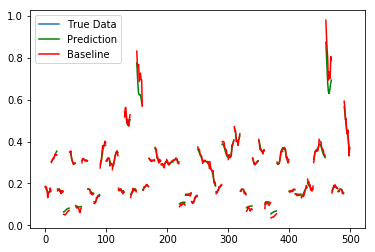

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

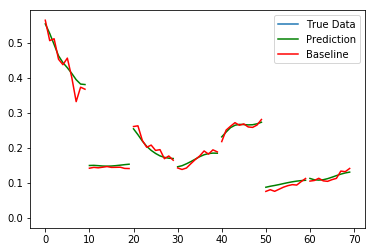

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.0001485515621214794
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.0001485515621214794


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

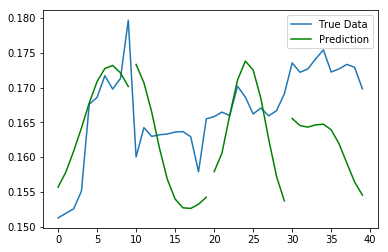

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

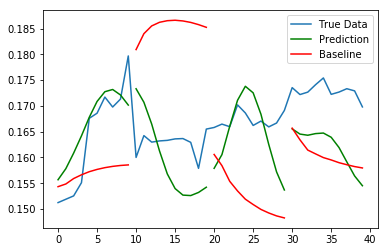

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.007218029821600136
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 7.139294943019416e-05


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



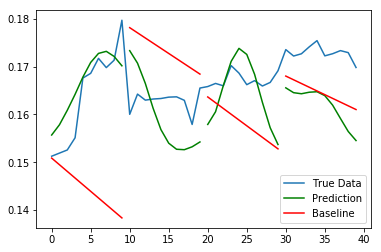

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.007218029821600136
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 7.139294943019416e-05


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

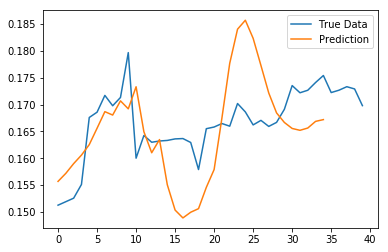

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

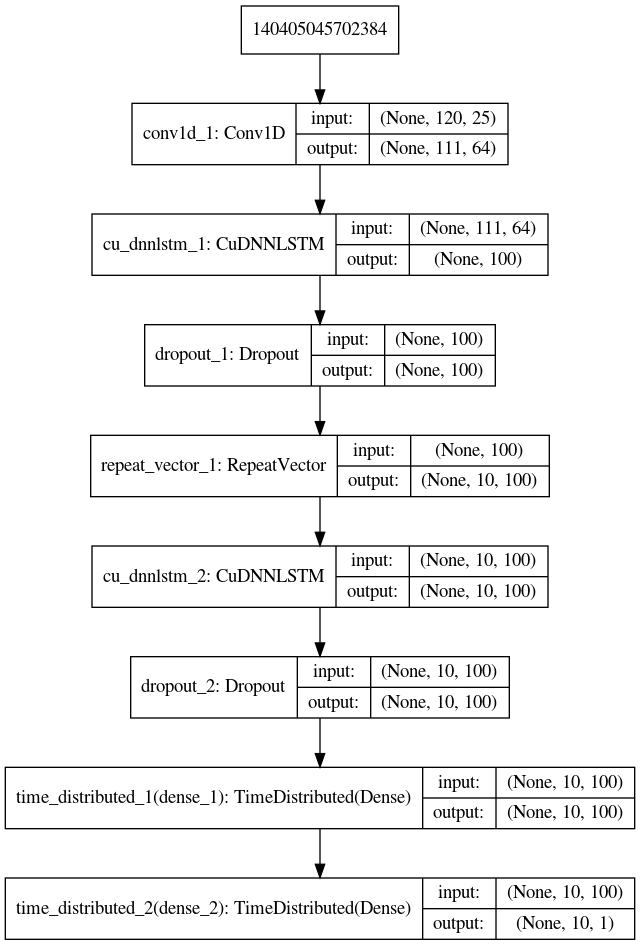

In [14]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))